## Denoising Autoencoders

In this notebook, we will learn to create a denoising autoencoder. We will be working with the [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist) image dataset. Specifically, we will corrupt the images with a noise, and train a DAE to output a uncorrupted image.

### Setup 

We will need the following libraries:

1. numpy
2. matplotlib
3. torch
4. torchvision

Please follow the instructions [here](https://pytorch.org/) to install the last two libraries. 

In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import math
import pathlib

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

### Data

PyTorch has simple-to-use functions that downloads and loads the datasets. We will use these functions to streamline our deep learning pipeline.

Checkout other image datasets at [torch.datasets](https://pytorch.org/vision/stable/datasets.html).

In [2]:
# download data in data folder. It will create this folder if it doesn't exist
torchvision.datasets.FashionMNIST(root="./data/", download=True)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

### Load data

The data has already been split into training and testing folders. We will make use of training dataset to train our DAE, and we will use test dataset in the end to check the quality of trained dataset. This way we will be able to compare the model's generalization performance on unseen dataset. 

In [3]:
# load data 
data = torchvision.datasets.FashionMNIST(root="./data/", train=True) # only load training data

How does the data look like?

- What is the type of data?
- What does each element of data represent?
- What are the constituent parts of each elements?
- How is the image represented?
- What do we use to plot image?
- How do we use the image in our model?

In [4]:
print("Type of data is the class\n", type(data))
print("Each element of the data is\n", type(data[0]))
print("A single element is\n", data[0],"first element is the image and the second element is the category")

Type of data is the class
 <class 'torchvision.datasets.mnist.FashionMNIST'>
Each element of the data is
 <class 'tuple'>
A single element is
 (<PIL.Image.Image image mode=L size=28x28 at 0x7F96502CFBD0>, 9) first element is the image and the second element is the category


### Image data

We know that the image data is present in `PIL.Image.Image` format. We need to convert it to array of pixel values to operate on it. We will also be displaying these images. `matplotlib.pyplot` has a simple function `plt.imshow()` to display matrix as an image.

Raw image to tensor shape: torch.Size([1, 28, 28])
2D image tensor shape: torch.Size([28, 28])


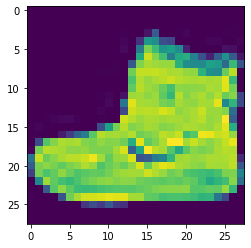

In [5]:
img = transforms.ToTensor()(data[0][0])
print(f"Raw image to tensor shape: {img.shape}")

# To plot this, we need a 2D array, so we use squeeze_(0) to remove first dimension
img = img.squeeze_(0)
print(f"2D image tensor shape: {img.shape}")

# how to display the image 
plt.imshow(img)

In [6]:
input_shape = img.shape

### Corruption model

We add noise according to a model. There are several models that can be used. We will be playing with the simple ones in this tutorial.

In [7]:
def corrupt_img(x, noise_model="gaussian"):
    """
    Adds noise to the input
    
    Args:
        x (np.array): input to be corrupted
        noise_mode (str): noise model for corruption
    
    Returns:
        (np.array): x corrupted with the noise model 
    """
    dtype = x.dtype
    if noise_model == "gaussian":
        x += 0.1*np.random.normal(0, 1, x.shape)
        
    if noise_model == "speckle":
        x *= np.random.binomial(n=1, p=0.8, size=x.shape)
    
    return x.to(dtype)

Let's look at how the corrupted images look.

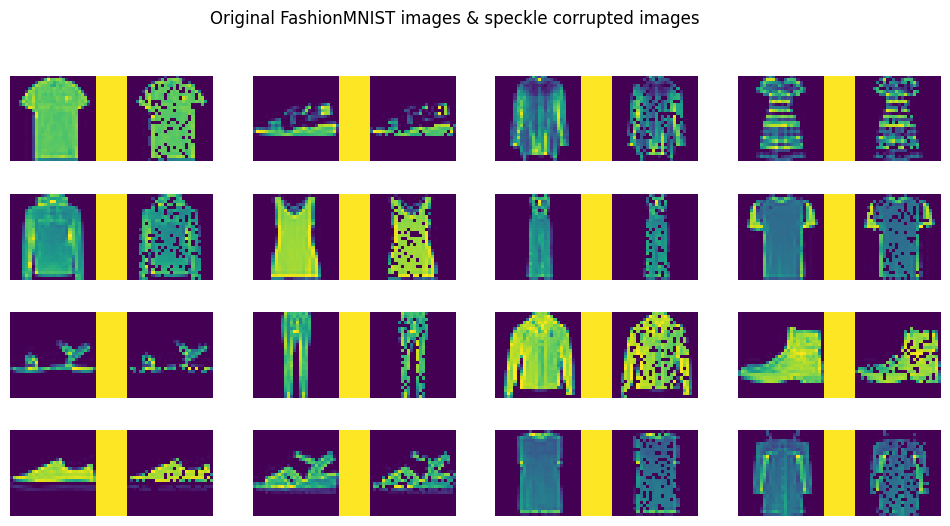

In [8]:
# visualize
n_samples = len(data)
n_vis = 16
noise_model = "speckle"

nrows = 4
ncols = math.ceil(n_vis/nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,6), dpi=100)

idxs = np.random.randint(low=0, high=n_samples, size=n_vis)

for i, idx in enumerate(idxs):
    ax = axs[i%nrows, i//nrows]
    img = transforms.ToTensor()(data[idx][0]).squeeze_(0)
    corrupted_img = corrupt_img(img, noise_model)
    concat_img = np.concatenate((img, np.ones((img.shape[0], 10)) ,corrupted_img), axis=1)
    ax.imshow(concat_img)
    ax.axis('off')

_ = fig.suptitle(f"Original FashionMNIST images & {noise_model} corrupted images  ")



### Denoising Autoencoder Model

We will be building our model in PyTorch. This is a standard way to define a model in PyTorch. `nn.Module` is a super class that contains all the functions necessary to build a computation graph and perform backward pass on it. 

Here we divide DAE into an encoder and decoder. While an encoder learns a lower dimensional representation of the corrupted input, the decoder learns to map it to the original input. These lower dimensional representations are hypothesized to be robust so that different noise on the same input should be mapped to the same point in this space, thereby being decoded to the original input.

Note that we used a sigmoid function on the output of the last layer. This lets us obtain the output in between 0 and 1, thereby matching the input range. 

In [9]:
# Denoising autoencoder; it is conceptually same as a deep autoencoder
class DAE(nn.Module):
    def __init__(self, input_shape):
        super(DAE, self).__init__()

        self.input_shape = input_shape
        self.in_dim = input_shape[0] * input_shape[1]

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.in_dim),
            nn.Sigmoid()
            )
    
    def forward(self, x):
        input = x.reshape(-1, self.in_dim)
        return self.decoder(self.encoder(input)).reshape(-1, self.input_shape[0], self.input_shape[1])
        

### Dataset loading

PyTorch uses `torch.utils.data.Dataset` class to load data in parallel on multiple CPUs. It enables faster loading of the batch of data. It then uses `torch.utils.data.DataLoader` to combine these loaded data points together into a batch. These batches are then used as an input to the models.

For this reason, we need to customize `__len__` and `__getitem__` functions in the class. This will help us do any necessary preprocessing on the images before using them as an input to the model.

In [10]:
# create a dataset 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, noise_model="gaussian"):
        self.data = data 
        self.noise_model = noise_model
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = transforms.ToTensor()(self.data[index][0]).squeeze_(0)
        corrupted_img = corrupt_img(img, self.noise_model)
        return (img, corrupted_img)        

### Data splitting

We split the training dataset into train and validation. This will help us tune hyperparameters of the model. Note that hyperparameter tuning is not done in this tutorial. 

In [11]:
# split data into train and val; we will create train_data at the start of every epoch
x_train, x_val = torch.utils.data.random_split(data, [54000, 6000])
val_data = torch.utils.data.DataLoader(Dataset(x_val), batch_size=256, shuffle=True)

### Optimizer 

We will use the standard Adam optimzer to learn the parameters.

In [12]:
# define your optimizer. It is just a template. we will define it again later just before startig the training.
model = DAE(input_shape)
optimizer = torch.optim.Adam(model.parameters())

### Loss 

We will create a function that will take following inputs:

1. DAE instance
2. `torch.utils.data.DataLoader` instance 
3. optimizer (optional)

This function returns the mean loss on this data. 

In [13]:
def process(model, data, optimizer=None):
    n_samples = 0
    running_loss = 0
    for img, corrupted_img in data:
        # transfer to GPU if avaiable
        img = img.to(device)
        corrupted_img = corrupted_img.to(device)

        n_samples += img.shape[0]
        
        # forward pass
        reconstructed_img = model(corrupted_img)
        loss = nn.MSELoss()(img, reconstructed_img) # reconstruction loss
        
        # backward pass 
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / n_samples
        

### Train

Finally, we will be running the training for `n_epochs` number of epochs. 
Each epoch consists of doing a backward pass on the subset of training data and evaluating the model on the validation data. 

In [14]:
# train

# fix seed for reproducibility 
rng = np.random.RandomState(1)
torch.manual_seed(rng.randint(np.iinfo(int).max))

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)

# create a model directory to store the best model
model_dir = pathlib.Path("./models").resolve()
if not model_dir.exists():
    model_dir.mkdir()

model = DAE(input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

epoch_size=200
batch_size=128

best_val_loss = np.inf
train_losses = []
val_losses = []
n_epochs = 30
no_improvement_cnt = 0
for epoch in range(n_epochs):
    print(f"@ epoch {epoch}", end="")
    
    # training loss
    idxs = rng.choice(len(x_train), epoch_size * batch_size, replace=True)
    train_data = torch.utils.data.DataLoader(Dataset([x_train[idx] for idx in idxs]), batch_size=batch_size, num_workers=4)
    train_loss = process(model, train_data, optimizer)
    
    # validation loss
    with torch.no_grad():
        val_loss = process(model, val_data)
    
    # save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_dir / "best.ckpt")
        no_improvement_cnt = 0
    else:
        
        # if there has been no improvement in validation loss, stop early
        no_improvement_cnt += 1
        
        if no_improvement_cnt % 10 == 0:
            print("\nEarly stopping!")
            break
        
    # logging
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"\ttrain_loss: {train_loss: .5f}, val_loss: {val_loss:.5f}")

print(f"best val loss: {best_val_loss:.5f}")

# load the best model
model = DAE(input_shape)
model.load_state_dict(torch.load(model_dir / "best.ckpt"))
model = model.to(device)

Using GPU: cuda
@ epoch 0	train_loss:  0.00050, val_loss: 0.00015
@ epoch 1	train_loss:  0.00024, val_loss: 0.00010
@ epoch 2	train_loss:  0.00019, val_loss: 0.00009
@ epoch 3	train_loss:  0.00017, val_loss: 0.00009
@ epoch 4	train_loss:  0.00017, val_loss: 0.00008
@ epoch 5	train_loss:  0.00016, val_loss: 0.00008
@ epoch 6	train_loss:  0.00015, val_loss: 0.00008
@ epoch 7	train_loss:  0.00015, val_loss: 0.00008
@ epoch 8	train_loss:  0.00014, val_loss: 0.00007
@ epoch 9	train_loss:  0.00014, val_loss: 0.00007
@ epoch 10	train_loss:  0.00014, val_loss: 0.00007
@ epoch 11	train_loss:  0.00013, val_loss: 0.00007
@ epoch 12	train_loss:  0.00013, val_loss: 0.00007
@ epoch 13	train_loss:  0.00013, val_loss: 0.00007
@ epoch 14	train_loss:  0.00013, val_loss: 0.00007
@ epoch 15	train_loss:  0.00013, val_loss: 0.00007
@ epoch 16	train_loss:  0.00012, val_loss: 0.00006
@ epoch 17	train_loss:  0.00012, val_loss: 0.00006
@ epoch 18	train_loss:  0.00012, val_loss: 0.00006
@ epoch 19	train_loss:  0

### Progress
 
Let's look at how the losses varied over epochs.

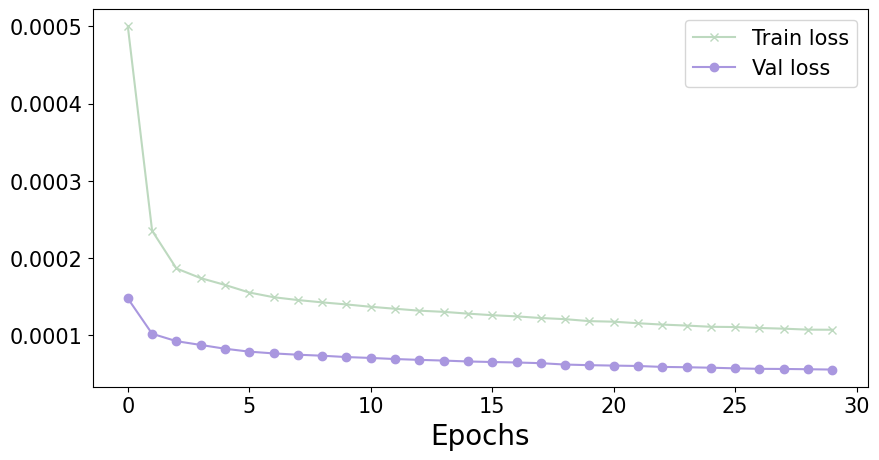

In [15]:
# plot losses
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

axs.plot(train_losses, color="#BDD9BF", marker="x", label="Train loss")
axs.plot(val_losses, color="#A997DF", marker="o", label="Val loss")
axs.set_xlabel("Epochs", fontsize=20)
axs.legend(prop={"size":15})

# tick size
for tick in axs.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)

for tick in axs.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)



### Test Evaluation

Finally, we will evaluate the model on the test dataset. Here we look at the reconstruction loss. 

In [16]:
# check test losses
test_data = torchvision.datasets.FashionMNIST(root="./data/", train=False)
test_dataloader = torch.utils.data.DataLoader(Dataset(test_data), batch_size=256)

with torch.no_grad():
    test_loss = process(model, test_dataloader)
print(f"Reconstruction loss on test dataset: {test_loss}")

Reconstruction loss on test dataset: 0.0034578695009462534


### Reconstructed images

Let's look at how well our model is able to reconstruct the corrupted images.

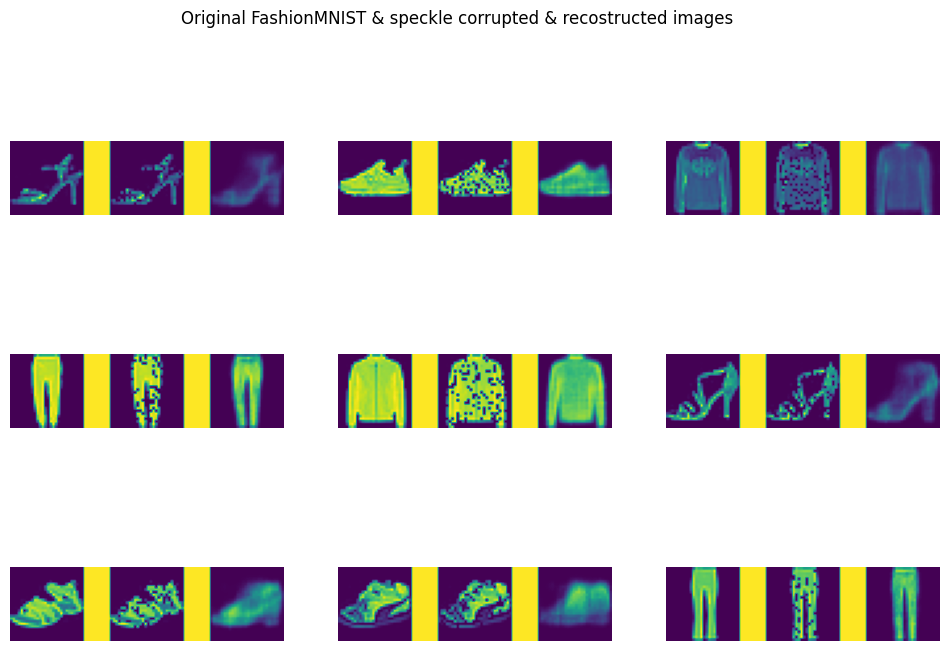

In [17]:
# check reconstructed images
model = model.cpu()
n_samples = len(test_data)
n_vis = 9

nrows = 3
ncols = math.ceil(n_vis/nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8), dpi=100)

idxs = np.random.randint(low=0, high=n_samples, size=n_vis)

for i, idx in enumerate(idxs):
    ax = axs[i%nrows, i//nrows]
    
    img = transforms.ToTensor()(test_data[idx][0]).squeeze_(0)
    
    corrupted_img = corrupt_img(img, noise_model)

    with torch.no_grad():
        reconstructed_img = model(corrupted_img.view(-1, *corrupted_img.shape)).squeeze_(0)
    
    filler =  np.ones((img.shape[0], 10))
    concat_img = np.concatenate((img, filler ,corrupted_img, filler, reconstructed_img), axis=1)
    
    ax.imshow(concat_img)
    ax.axis('off')

_ = fig.suptitle(f"Original FashionMNIST & {noise_model} corrupted & recostructed images ")

